# Computational Exercise 11: Human Activity Recognition

**Please note that (optionally) this assignment may be completed in groups of 2 students.**

---
In this exercise...

Goals are as follows:

- Goal 1
- Goal 2

We'll begin by importing required libraries:

- numpy for efficient math operations
- tensorflow for defining and training our RNN
- matplotlib for visualization/plotting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

## Download the dataset

In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip".replace(" ", "%20")

with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('HAR')

In [12]:
train_dir = 'HAR/UCI HAR Dataset/train/Inertial Signals'
train_files = os.listdir(train_dir)

print(train_files)

['body_gyro_z_train.txt', 'body_acc_y_train.txt', 'total_acc_z_train.txt', 'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_x_train.txt', 'body_acc_z_train.txt']


In [ ]:
x_train = np.concatenate([
    pd.read_table(
        os.path.join(train_dir, fn),
        header=None, sep='\s+').values[:, :, np.newaxis]
    for fn in train_files], axis=2)

x_mean = x_train.mean(axis=1).mean(axis=0)
x_std = x_train.std(axis=1).mean(axis=0)

x_train = (x_train - x_mean) / x_std

In [8]:
test_dir = 'HAR/UCI HAR Dataset/test/Inertial Signals'

x_test = np.concatenate([
    pd.read_table(
        os.path.join(test_dir, fn.replace('train', 'test')),
        header=None, sep='\s+').values[:, :, np.newaxis]
    for fn in train_files], axis=2)

x_test = (x_test - x_mean) / x_std

In [10]:
y_train = pd.read_table(
    'HAR/UCI HAR Dataset/train/y_train.txt',
    header=None, squeeze=True
).values - 1

In [11]:
y_test = pd.read_table(
    'HAR/UCI HAR Dataset/test/y_test.txt',
    header=None, squeeze=True
).values - 1

## Exercise 11.1: Exploring the data

In as many blocks as needed, explore the dataset, including:
- Determine the shape of `x_train`, `x_test`, `y_train`, and `y_test`
- Count the number of each type of label in `y_train` and `y_test`
- Plot (using `plt.plot`) at least one inertial signal over time for at least one example. To do this, note that in `x_train`, the different examples are stacked along axis 0, time varies along axis 1, and the inertial signal varies along axis 2 (e.g. rotation and acceleration in each direction)

In [14]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7352, 128, 9), (7352,), (2947, 128, 9), (2947,))

In [13]:
pd.value_counts(y_train)

5    1407
4    1374
3    1286
0    1226
1    1073
2     986
dtype: int64

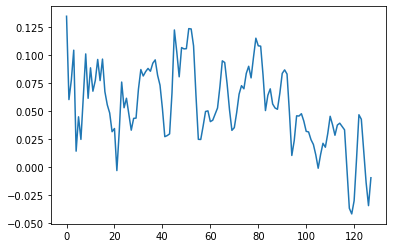

In [15]:
plt.plot(x_train[0, :, 0])
plt.show()

## Exercise 11.2: Extract features

In [16]:
x_train_features = np.concatenate(
    [
        x_train.mean(axis=1),
        x_train.std(axis=1),
        x_train.max(axis=1),
        x_train.min(axis=1)
    ],
    axis=1
)

x_test_features = np.concatenate(
    [
        x_test.mean(axis=1),
        x_test.std(axis=1),
        x_test.max(axis=1),
        x_test.min(axis=1)
    ],
    axis=1
)

x_train_features.shape, x_test_features.shape

((7352, 36), (2947, 36))

## Exercise 11.3: Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(x_train_features, y_train)

y_pred = lr_model.predict(x_test_features)
print('The accuracy is %.1f' % (100 * np.mean(y_pred == y_test)))

The accuracy is 0.841533763148965


## Exercise 11.4: LSTM

In [19]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Model

class MyLSTM(Model):
    def __init__(self):
        super(MyLSTM, self).__init__()
        self.lstm = LSTM(36)
        self.fc = Dense(6)

    def call(self, x):
        x = self.lstm(x)
        return self.fc(x)

In [20]:
model = MyLSTM()

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # multi-class cross-entropy loss
optimizer = tf.keras.optimizers.Adam() # modified stochastic gradient descent optimizer

In [22]:
# create tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train.astype('float32'), y_train)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test.astype('float32'), y_test)).batch(32)

In [23]:
EPOCHS = 15

for epoch in range(EPOCHS):

    train_accuracy = []
    test_accuracy = []
  
    for i, (x, y) in enumerate(train_ds):
        
        print('Running training batch %i of %i' % (i, len(train_ds)), end='\r')
    
        with tf.GradientTape() as tape:
            predicted_logits = model(x)
            loss = loss_object(y, predicted_logits)

        y_pred = np.argmax(predicted_logits, axis=1)
        batch_accuracy = np.mean(y_pred == y)
        train_accuracy.append(batch_accuracy)
    
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    for i, (x, y) in enumerate(test_ds):
        
        print('Running test batch %i of %i' % (i, len(test_ds)), end='\r')
    
        predicted_logits = model(x)
        y_pred = np.argmax(predicted_logits, axis=1)
    
        batch_accuracy = np.mean(y_pred == y)
        test_accuracy.append(batch_accuracy)

    train_accuracy = 100 * np.mean(train_accuracy)
    test_accuracy = 100 * np.mean(test_accuracy)
        
    print('Epoch %i: train accuracy = %.1f%%, test accuracy = %.1f%%' % (
        epoch, train_accuracy, test_accuracy))

Epoch 0: train accuracy = 59.8%, test accuracy = 71.5%
Epoch 1: train accuracy = 80.8%, test accuracy = 79.0%
Epoch 2: train accuracy = 88.0%, test accuracy = 84.3%
Epoch 3: train accuracy = 91.6%, test accuracy = 81.5%
Epoch 4: train accuracy = 92.4%, test accuracy = 87.0%
Epoch 5: train accuracy = 93.9%, test accuracy = 87.1%
Epoch 6: train accuracy = 94.8%, test accuracy = 86.9%
Epoch 7: train accuracy = 95.1%, test accuracy = 88.5%
Epoch 8: train accuracy = 94.0%, test accuracy = 89.2%
Epoch 9: train accuracy = 94.3%, test accuracy = 89.0%
Epoch 10: train accuracy = 93.7%, test accuracy = 88.8%
Epoch 11: train accuracy = 94.6%, test accuracy = 88.2%
Epoch 12: train accuracy = 94.9%, test accuracy = 89.4%
Epoch 13: train accuracy = 95.3%, test accuracy = 88.9%
Epoch 14: train accuracy = 95.2%, test accuracy = 90.6%
